In [8]:
import numpy as np
import scipy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
test_dir = 'FER-2013/test'  
train_dir = 'FER-2013/train'   

In [10]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    brightness_range =[0.8,1.2],
    shear_range = 0.15,
    horizontal_flip=True
)

datagen_val = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),    # FER images are typically 48x48
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen_val.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
)
from tensorflow.keras.optimizers import Adam

def build_emotion_model(input_shape=(48, 48, 3), num_classes=7):
    # Load EfficientNetB0 as the base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    base_model.trainable = False

    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Add a custom classification head
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build and summarize the model
model = build_emotion_model()
model.summary()


2024-11-21 14:03:52.530643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 104 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:19:00.0, compute capability: 6.1
2024-11-21 14:03:52.531273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11395 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:1a:00.0, compute capability: 6.1
2024-11-21 14:03:52.531731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 11395 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:67:00.0, compute capability: 6.1
2024-11-21 14:03:52.532227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11387 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:68:00.0, comput

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 2, 2, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                             

In [15]:
# Custom CNN
# model = Sequential([
#     Conv2D(256, (3, 3), activation='relu', input_shape=(48, 48, 1)),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),
#     Dropout(0.3),

#     Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),
#     Dropout(0.3),

#     Conv2D(64, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),
#     Dropout(0.3),

#     Flatten(),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(7, activation='softmax')  # Adjust if there are more/less classes
# ])

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 2, 2, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                             

In [18]:
history = model.fit(train_generator, validation_data=val_generator, epochs=30, verbose=1)

Epoch 1/30


2024-11-21 14:04:01.705052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-21 14:04:01.881283: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 38.51MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-21 14:04:01.881323: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 67.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-21 14:04:02.003212: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 70.88MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains i

449/449 [==============================] - 42s 82ms/step - loss: 2.2449 - accuracy: 0.1898 - val_loss: 1.9777 - val_accuracy: 0.2471
Epoch 2/30
449/449 [==============================] - 36s 80ms/step - loss: 1.8992 - accuracy: 0.2283 - val_loss: 2.9671 - val_accuracy: 0.2478
Epoch 3/30
449/449 [==============================] - 36s 80ms/step - loss: 1.8228 - accuracy: 0.2452 - val_loss: 15.1091 - val_accuracy: 0.1158
Epoch 4/30
449/449 [==============================] - 36s 79ms/step - loss: 1.8045 - accuracy: 0.2514 - val_loss: 2.7526 - val_accuracy: 0.2503
Epoch 5/30
449/449 [==============================] - 35s 79ms/step - loss: 1.7978 - accuracy: 0.2510 - val_loss: 3.4164 - val_accuracy: 0.1718
Epoch 6/30
449/449 [==============================] - 35s 78ms/step - loss: 1.7937 - accuracy: 0.2536 - val_loss: 4.0946 - val_accuracy: 0.1335
Epoch 7/30
 48/449 [==>...........................] - ETA: 29s - loss: 1.7813 - accuracy: 0.2604

KeyboardInterrupt: 

In [ ]:
model.save("v1-tl.h5")

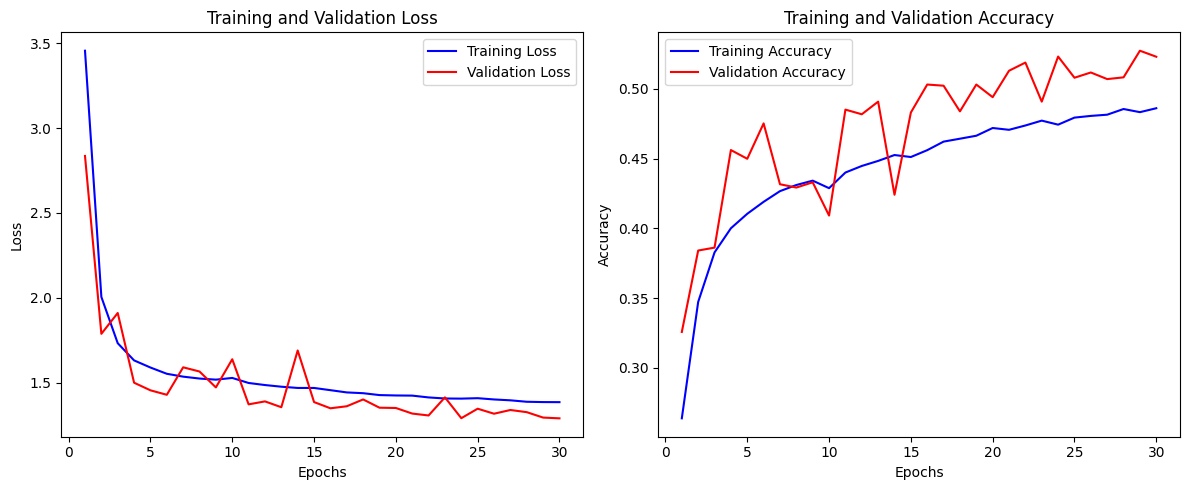

In [14]:
import matplotlib.pyplot as plt

# Extract data from history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Get the number of epochs
epochs = range(1, len(loss) + 1)

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
